In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import cm

import matplotlib.lines as mlines

%matplotlib inline

### Air Pollution Monitoring Data From EDF

In [15]:
df = pd.read_csv('EDF_Data.csv', header = 1)
df['TimePeriod'] = 'Jun2015-May2016'
df.head()

,Longitude,Latitude,NO Value,NO2 Value,BC Value,TimePeriod
0,-122.322594,37.806781,23.390071,17.539762,0.818032,Jun2015-May2016
1,-122.322310,37.806150,19.700000,19.956750,0.551475,Jun2015-May2016
2,-122.322301,37.806420,23.611111,23.967768,0.593712,Jun2015-May2016
3,-122.322299,37.805880,15.714285,18.435184,0.489898,Jun2015-May2016
4,-122.322267,37.806689,27.108695,25.797037,0.739341,Jun2015-May2016


In [16]:
df.shape

(21488, 6)

In [17]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

### METEROLOGICAL DATASET

In [20]:
df_met = pd.read_csv("MetStations_CA.csv")
df_met.head()

,STATION_ID,STATION,BEGIN_DATE,END_DATE,STATE,COUNTRY,LATITUDE,LONGITUDE,ELEVATION_(M)
0,WBAN:23239,"ALAMEDA NAS, CA US",1945-02-28,1997-01-31,California,United States,37.78333,-122.31667,9.1
1,WBAN:94299,"ALTURAS MUNICIPAL AIRPORT, CA US",2004-12-31,2020-02-23,California,United States,41.49139,-120.56444,1333.5
2,WBAN:24283,"ARCATA EUREKA AIRPORT, CA US",1949-11-30,2020-02-23,California,United States,40.97806,-124.10861,61.0
3,WBAN:23224,"AUBURN MUNICIPAL AIRPORT, CA US",2004-12-31,2020-02-23,California,United States,38.95472,-121.08194,466.6
4,WBAN:23191,"AVALON CATALINA AIRPORT, CA US",1943-06-11,2020-02-23,California,United States,33.40500,-118.41583,488.3


In [21]:
crs = {'init': 'epsg:4326'}
geometry_met = [Point(xy) for xy in zip(df_met['LONGITUDE'], df_met['LATITUDE'])]
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
geo_df_met = gpd.GeoDataFrame(df_met, crs = crs, geometry = geometry_met)

### Finding Closest Met Station to get average wind speed, temperature and elevation data

In [22]:
# Unary Union of the geo_df geometry

pts = geo_df_met.geometry.unary_union
def near(point, pts=pts):
     # find the nearest point and return the corresponding Station name
     nearest = geo_df_met.geometry == nearest_points(point, pts)[1]
     return geo_df_met[nearest].STATION.to_numpy()[0]
geo_df['Nearest_Station'] = geo_df.apply(lambda row: near(row.geometry), axis=1)

In [23]:
geo_df['Nearest_Station'].unique()

array(['ALAMEDA NAS, CA US', 'OAKLAND METROPOLITAN, CA US',
       'HAYWARD AIR TERMINAL, CA US'], dtype=object)

## Loading Facility Level data from National Emissions Inventory (Do not Run the following cells, jump to Oakland data)

In [ ]:
#Loading entire facility level data from US EPA
facility = pd.read_csv('Data/2017_NEI_Facilities.csv')

In [ ]:
# Selecting only facilities that are located in Alameda county in California
facility = facility[(facility['state'] == 'CA') & (facility['county'] == 'Alameda')]

In [ ]:
facility.columns

In [ ]:
# Dropping columns that are unneccessary
facility.drop(columns = ['epa region code', 'state', 'fips state code', 'tribal name', 'fips code','program system code',
                        'naics code','naics description','postal abbreviation','reporting period','emissions operating type',
                         'pollutant desc'], inplace = True)

#### As per the national emissions inventory, PM10-PRI includes both filterable PM10 and PM10 from condensibles. Similarly PM25-PRI includes filterable and condensible PM2.5 emissions.  Since PM10-Primary and PM2.5-Primary are the closest compounds to black carbon, this analysis uses both pollutants. 

In [ ]:
#Selecting only pollutants like PM and nitrogen oxides since we have concentration data just for those
facility = facility[(facility['pollutant code'] == 'PM10-PRI') |(facility['pollutant code'] == 'PM25-PRI') | (facility['pollutant code'] == 'NOX')]

In [ ]:
facility['pollutant code'].unique()

In [ ]:
## Writing into a new csv file and removing facility level file
facility.to_csv('Data/oakland_facility_2017.csv')

## Reading Oakland Level Facility data from National Emissions Inventory

In [24]:
# Read data for Oakland and drop duplicate facility ids
oak_facility = pd.read_csv('Data/oakland_facility_2017.csv', header = 0)
# Display all columns in the dataframe
oak_facility.columns

Index(['Unnamed: 0', 'county', 'eis facility id', 'agency facility id',
       'tri facility id', 'company name', 'site name', 'facility source type',
       'site latitude', 'site longitude', 'address', 'city', 'zip code',
       'pollutant code', 'pollutant type(s)', 'total emissions',
       'emissions uom', 'data set'],
      dtype='object')

In [25]:
# Drop columns that are not needed 
oak_facility.drop(columns = ['agency facility id', 'tri facility id','pollutant type(s)', 'data set', 'address',
                             'site name','facility source type','Unnamed: 0', 'county'], inplace=True)

In [26]:
# Rename site latitude and site longitude column to just latitude and logitude
oak_facility.rename(columns={"site latitude": "latitude", "site longitude": "longitude"}, inplace=True)

In [27]:
# Display all columns in the dataframe
oak_facility.columns

Index(['eis facility id', 'company name', 'latitude', 'longitude', 'city',
       'zip code', 'pollutant code', 'total emissions', 'emissions uom'],
      dtype='object')

In [28]:
# Filter the dataframe further for sources/facilities only in Oakland and neighbouring cities like San Leandro, Piedmont, Alameda and Berkeley
oak_facility = oak_facility[(oak_facility['city'] == 'OAKLAND') | (oak_facility['city'] == 'SAN LEANDRO') | (oak_facility['city'] == 'BERKELEY')|
                           (oak_facility['city'] == 'ALAMEDA') | (oak_facility['city'] == 'PIEDMONT')]

In [29]:
oak_facility.head()

,eis facility id,company name,latitude,longitude,city,zip code,pollutant code,total emissions,emissions uom
3,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,94501,NOX,0.054659,TON
4,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,94501,PM10-PRI,0.000749,TON
5,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,94501,PM25-PRI,0.000731,TON
9,127111,PACIFIC BELL,37.86771,-122.26784,BERKELEY,94704,NOX,0.162383,TON
10,127111,PACIFIC BELL,37.86771,-122.26784,BERKELEY,94704,PM10-PRI,0.002226,TON


In [30]:
## Creating a separate dataframe for NOx
Oak_NOx = oak_facility[oak_facility['pollutant code'] == 'NOX']

In [31]:
Oak_NOx.shape

(328, 9)

In [32]:
## Creating a separate dataframe for PM/Black carbon
Oak_PM10_25 = oak_facility[oak_facility['pollutant code'] != 'NOX']

In [33]:
PM10_pri = Oak_PM10_25[Oak_PM10_25['pollutant code']=='PM10-PRI']

In [34]:
## Drop PM10-PRI rows in Oak_PM dataframe
Oak_PM25  = Oak_PM10_25[Oak_PM10_25['pollutant code'] == 'PM25-PRI']

In [35]:
Oak_PM = pd.merge(Oak_PM25, PM10_pri, left_on ='eis facility id', right_on ='eis facility id', how='inner')


In [36]:
Oak_PM

,eis facility id,company name_x,latitude_x,longitude_x,city_x,zip code_x,pollutant code_x,total emissions_x,emissions uom_x,company name_y,latitude_y,longitude_y,city_y,zip code_y,pollutant code_y,total emissions_y,emissions uom_y
0,126911,PACIFIC BELL,37.766850,-122.249720,ALAMEDA,94501,PM25-PRI,0.000731,TON,PACIFIC BELL,37.766850,-122.249720,ALAMEDA,94501,PM10-PRI,0.000749,TON
1,127111,PACIFIC BELL,37.867710,-122.267840,BERKELEY,94704,PM25-PRI,0.002173,TON,PACIFIC BELL,37.867710,-122.267840,BERKELEY,94704,PM10-PRI,0.002226,TON
2,127511,PACIFIC BELL,37.806030,-122.269460,OAKLAND,94612,PM25-PRI,0.008291,TON,PACIFIC BELL,37.806030,-122.269460,OAKLAND,94612,PM10-PRI,0.008494,TON
3,127611,PACIFIC BELL,37.784220,-122.222410,OAKLAND,94601,PM25-PRI,0.000706,TON,PACIFIC BELL,37.784220,-122.222410,OAKLAND,94601,PM10-PRI,0.000724,TON
4,127711,PACIFIC BELL,37.833360,-122.263070,OAKLAND,94609,PM25-PRI,0.001554,TON,PACIFIC BELL,37.833360,-122.263070,OAKLAND,94609,PM10-PRI,0.001592,TON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,18778911,NaN,37.712960,-122.188680,SAN LEANDRO,94577,PM25-PRI,22.124544,TON,NaN,37.712960,-122.188680,SAN LEANDRO,94577,PM10-PRI,22.971518,TON
358,18779811,NaN,37.707820,-122.185500,SAN LEANDRO,94577,PM25-PRI,0.000015,TON,NaN,37.707820,-122.185500,SAN LEANDRO,94577,PM10-PRI,0.000015,TON
359,18781211,NaN,37.812106,-122.186447,OAKLAND,94621,PM25-PRI,0.000061,TON,NaN,37.812106,-122.186447,OAKLAND,94621,PM10-PRI,0.000061,TON
360,18782611,NaN,37.759959,-122.207782,OAKLAND,94621,PM25-PRI,0.992654,TON,NaN,37.759959,-122.207782,OAKLAND,94621,PM10-PRI,1.030213,TON


In [37]:
Oak_PM.drop(columns = ['zip code_x','pollutant code_x', 'emissions uom_x','company name_y','latitude_y','longitude_y',
                      'city_y','zip code_y','pollutant code_y','emissions uom_x'], inplace=True)

In [38]:
# Rename columns to meaningful names
Oak_PM.rename(columns={"latitude_x": "latitude", "longitude_x": "longitude", "city_x": "city", 
                       "total emissions_x" : "PM25", "total emissions_y": "PM10", "emissions uom_y": "units"}, inplace=True)

In [39]:
Oak_PM.head()

,eis facility id,company name_x,latitude,longitude,city,PM25,PM10,units
0,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,0.000731,0.000749,TON
1,127111,PACIFIC BELL,37.86771,-122.26784,BERKELEY,0.002173,0.002226,TON
2,127511,PACIFIC BELL,37.80603,-122.26946,OAKLAND,0.008291,0.008494,TON
3,127611,PACIFIC BELL,37.78422,-122.22241,OAKLAND,0.000706,0.000724,TON
4,127711,PACIFIC BELL,37.83336,-122.26307,OAKLAND,0.001554,0.001592,TON


In [40]:
Oak_PM.shape

(362, 8)

## Converting the facility dataframe into a geopandas dataframe for plotting

In [41]:
# Create a list of x and y coordinates to convert to a geodataframe using geopandas
geometry_facility = [Point(xy) for xy in zip(oak_facility['longitude'], oak_facility['latitude'])]

In [42]:
# Create a geopandas dataframe with the coordinate reference system as epsg4326
geo_df_facility = gpd.GeoDataFrame(oak_facility, crs = crs, geometry = geometry_facility)

## Pu(lo)tting all together  

### Plotting Oakland Basemap (shapefile)

In [43]:
oakl = gpd.read_file('Oakland-shapefile/OaklandZoning_Eff20181211_Ord13513.shp')

In [44]:
oakl.head()

,FID,OBJECTID,AREA,PERIMETER,BASEZONE,OVERLAY,ZNLABEL,ORDINANCE,LASTUPDATE,GLOBALID,SHAPE_AREA,SHAPE_LEN,Shape__Are,Shape__Len,geometry
0,1,2564,463428.469786,3325.153525,RM-3,None,RM-3,None,20180327,{9D6F625B-B567-4B94-86EF-A5BCB06DC547},463428.469786,3325.153525,69024.062500,1283.361119,"POLYGON ((-122.19994 37.76732, -122.20039 37.7..."
1,2,1813,558079.266415,6474.259271,OS (RCA),None,OS (RCA),13276,20180327,{A2EC4B15-CBDD-499C-8660-B70F90566564},558079.266419,6474.259271,83181.558594,2501.498512,"POLYGON ((-122.25921 37.79733, -122.25922 37.7..."
2,3,2139,43129.700341,1086.970123,CC-2,/S-7,CC-2/S-7,None,20180327,{BF636AD7-DD80-47FA-B2D0-97614B55EC75},43129.700340,1086.970123,6430.570312,419.525144,"POLYGON ((-122.29849 37.80666, -122.29850 37.8..."
3,4,2565,104035.317933,1328.336204,RM-3,None,RM-3,None,20180327,{A6197605-035A-4F64-AD67-084FB60661D7},104035.317934,1328.336204,15495.957031,512.707291,"POLYGON ((-122.19655 37.76915, -122.19627 37.7..."
4,5,1814,553731.995607,3549.473783,CC-1,None,CC-1,None,20180327,{30FA7150-F5A0-489F-8415-2018DBB78376},553731.995610,3549.473783,82541.093750,1370.391443,"POLYGON ((-122.18167 37.79756, -122.18167 37.7..."


In [45]:
oakl.crs

{'init': 'epsg:4326'}

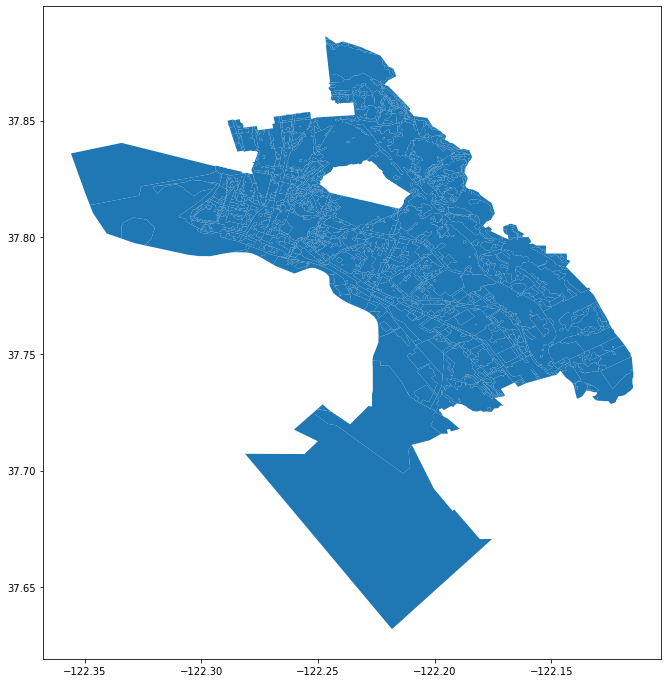

In [46]:
fig, ax = plt.subplots(figsize = (12,12))
oakl.plot(ax = ax)

#### Plotting black carbon data and location of all near-by sources

In [47]:
### First create legend handles for facilities


maroon_x = mlines.Line2D([], [], color='maroon', marker='x', linestyle='None',
                          markersize=6, label='Alameda')
orange_x = mlines.Line2D([], [], color='darkorange', marker='x', linestyle='None',
                          markersize=6, label='Berkeley')
yellow_x = mlines.Line2D([], [], color='lemonchiffon', marker='x', linestyle='None',
                          markersize=6, label='Oakland')
green_x = mlines.Line2D([], [], color='limegreen', marker='x', linestyle='None',
                          markersize=6, label='Oakland')
blue_x = mlines.Line2D([], [], color='slateblue', marker='x', linestyle='None',
                          markersize=6, label='Oakland')



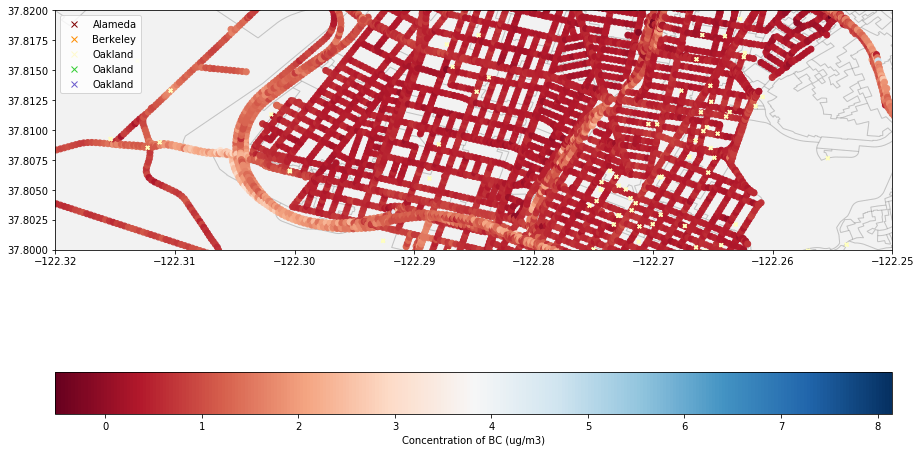

In [52]:

fig, ax = plt.subplots(figsize = (15,15)) #This creates a figure axis
vmin = geo_df['BC Value'].min()           #Minimum value of black carbon concentration for legend
vmax = geo_df['BC Value'].max()           #Maximum value of black carbon concentration for legend
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile


geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
plt.xlim([-122.32,-122.25])
#plt.ylim([37.76,37.9])
plt.ylim([37.8,37.82])


#cax = fig.add_axes([1, 0.05, 0.03, 0.8])
sm = cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
#sm._A = []
#cbr = fig.colorbar(sm)
#cbr.ax.tick_params(labelsize=20) 
ax.get_figure().colorbar(sm, ax=ax, orientation='horizontal', label = 'Concentration of BC (ug/m3)')
geo_df_facility.plot(ax=ax, cmap='Spectral', column = 'city', legend = True, marker='x', markersize = 12)
plt.legend(handles=[maroon_x, orange_x, yellow_x, green_x, blue_x])
#geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
#                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.tight_layout()
#plt.savefig(os.path.join('out','fig.png'),format = 'png',bbox_inches='tight')
plt.show()

#### Plotting NOx data and location of all near-by sources

In [ ]:
fig, ax = plt.subplots(figsize = (15,15)) #This creates a figure axis
vmin = geo_df['NO2 Value'].min()           #Minimum value of black carbon concentration for legend
vmax = geo_df['NO2 Value'].max()           #Maximum value of black carbon concentration for legend
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile


geo_df.plot(ax = ax, column = 'NO2 Value', legend=False, legend_kwds={'label': "Concentration of NO",
                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.xlim([-122.25,-122.15])
#plt.ylim([37.7,37.9])


#cax = fig.add_axes([1, 0.05, 0.03, 0.8])
sm = cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
#sm._A = []
#cbr = fig.colorbar(sm)
#cbr.ax.tick_params(labelsize=20) 
ax.get_figure().colorbar(sm, ax=ax, orientation='horizontal', label = 'Concentration of NO2 (ppb)')
geo_df_facility.plot(ax=ax, cmap='Spectral', column = 'city', legend = True, marker='x', markersize = 12)
plt.legend(handles=[maroon_x, orange_x, yellow_x, green_x, blue_x])
#geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
#                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.tight_layout()
#plt.savefig(os.path.join('out','fig.png'),format = 'png',bbox_inches='tight')
plt.show()